# <center> Lending Club Case Study


## Table of Content

1. [Introduction](#Introduction)
2. [Important Settings](#Important-Settings)
3. [Data Understanding](#Data-Understanding)  
4. [Data Cleaning and Manipulation](#Data-Cleaning-and-Manipulation)
    1. [Dropping Data](#Dropping-Data)
    2. [Formatting Data](#Formatting-Data)
    3. [Derived Data](#Derived-Data)
5. [Data Analysis](#Data-Analysis)
    1. [Univariable Analysis](#Univariable-Analysis)
        1. [Plot Numeric Data](#Plot-Numeric-Data)
        2. [Plot Categorical Data](#Plot-Categorical-Data)
    2. [Bivariable Analysis](#Bivariable-Analysis)
6. [Preparing the Data for Modeling](#Preparing-the-Data-for-Modeling)
7. [Model Building](#Model-Building)
8. [Model Evaluation](#Model-Evaluation)
7. [Conclusions and Observations](#Conclusions-and-Observations)

# Introduction 

### Contact:
* Jheser Guzman (https://github.com/dicotips)

## Business Understanding

**Source:** UpGrad Assignment description

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

A US bike-sharing provider **BoomBikes** has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

* Which variables are significant in predicting the demand for shared bikes.
* How well those variables describe the bike demands

Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors.

### Business Goal:

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market.

# Important Initial Settings

In [91]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Importing ML Libaries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ignore version warnings
import warnings
warnings.filterwarnings('ignore')

# Setting the format of Float numbers to two digits.
pd.options.display.float_format = '{:.2f}'.format 

In [92]:
# Reading CSV file with dtype object and saving it in raw_data dataframe. 
# All the processing in the data will be stored in new dataframes

# Set Dataset File Path
DATA_FILE_PATH = '_data/data.csv'

raw_data = pd.read_csv(DATA_FILE_PATH)

### Important Custom Functions

In [93]:
def univar_plot(dataframe, column, var_type , hue = None):
    
    '''
    univar_plot function plots a column from a dataframe.
    dataframe  : dataframe variable
    column     : Column name
    var_type   : variable type to specify i it is continuos or categorical
                Continuos=0   ==> Graph contains:  Distribution, Violin & Boxplot.
                Categorical=1 ==> Graph contains:  Countplot.
    hue        : Only for categorical data (coloring).
    
    '''
    sns.set(style="darkgrid")
    
    if var_type == 0:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
        
        ax[0].set_title("Distribution Plot")
        sns.distplot(dataframe[column],ax=ax[0])
        
        ax[1].set_title("Violin Plot")
        sns.violinplot(data=dataframe, x=column, ax=ax[1], inner = "quartile")
        
        ax[2].set_title("Box Plot")
        sns.boxplot(data=dataframe, x=column, ax=ax[2], orient='v')
    
    if var_type == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(dataframe[column].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = dataframe, x=column, order=dataframe[column].value_counts().index, hue=hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(dataframe))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

# Data Understanding
* Ensure data quality:  identify issues and report them. 
* Interpreted the meaning of the variables and describe the actions in as comments.

In [94]:
# Getting the first 5 rows from the raw_data dataframe for data exploration
raw_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.11,18.18,80.58,10.75,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.90,17.69,69.61,16.65,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.05,9.47,43.73,16.64,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.20,10.61,59.04,10.74,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.31,11.46,43.70,12.52,82,1518,1600


In [95]:
# Understanding the structure of the dataset
# Checking shape & datatype of raw_data dataframe
print(raw_data.shape)
print(raw_data.info())

(730, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None


In [96]:
print(raw_data.dtypes)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


In [97]:
# Statistical description of Data
raw_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00
mean,365.50,2.50,0.50,6.53,0.03,3.00,0.68,1.39,20.32,23.73,62.77,12.76,849.25,3658.76,4508.01
std,210.88,1.11,0.50,3.45,0.17,2.01,0.47,0.54,7.51,8.15,14.24,5.20,686.48,1559.76,1936.01
min,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,2.42,3.95,0.00,1.50,2.00,20.00,22.00
25%,183.25,2.00,0.00,4.00,0.00,1.00,0.00,1.00,13.81,16.89,52.00,9.04,316.25,2502.25,3169.75
50%,365.50,3.00,0.50,7.00,0.00,3.00,1.00,1.00,20.47,24.37,62.62,12.13,717.00,3664.50,4548.50
75%,547.75,3.00,1.00,10.00,0.00,5.00,1.00,2.00,26.88,30.45,72.99,15.63,1096.50,4783.25,5966.00
max,730.00,4.00,1.00,12.00,1.00,6.00,1.00,3.00,35.33,42.04,97.25,34.00,3410.00,6946.00,8714.00


In [98]:
# Comments

# * Data seems to not have outliers.
# * The "Mean" and "Median" are close to each other.

In [99]:
# We verify if there is any dublicated rows in ['instant']

print(raw_data.duplicated(subset=None, keep='first').count())
sum(raw_data.duplicated(['instant']))

## Result: There are no duplicated in "instant" !!!

730


0

In [100]:
# Checking how many rows have all missing values
empty_rows = raw_data.isnull().all(axis=1).sum()
print(f'N Empty Rows: {empty_rows}')

## Result: There are no rows with missing Values

N Empty Rows: 0


In [101]:
# Checking how many columns have all missing values
empty_columns = raw_data.isnull().all(axis=0).sum()
print(f'N Empty Columns: {empty_columns}')

## Result: There are no columins with missing values.

N Empty Columns: 0


In [102]:
# Counting Nulls in each column
raw_data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [103]:
# Data Undrstanding Comments.

# * There are total 730 records and 16 Columns with no missing values.
# * Number of float64 columns are 4, int64 columns are 11, and object columns are only 1.
# * Data type of dteday column has to be corrected.
# * Season, weekday and yr columns have to be mapped with the currect meaning for analysis.
# * All are numerical data type but 'dteday'.

## Data Preparation

* Data quality issues are addressed
 * Missing value imputation.
 * Outlier treatment.
 * Remove data redundancies.
* If needed, converted data to a suitable and convenient format to work with using the right methods.
* Manipulation of strings and dates is done correctly wherever required.

### Dropping Data

In [104]:
# Verifying how much memory is used by raw_data dataframe
raw_data_size_mb = format(sys.getsizeof(raw_data) /(1028**2), '.0f')

print(f'Raw_Data Memory Usage: {raw_data_size_mb}MB')

Raw_Data Memory Usage: 0MB


In [105]:
# Creating a copy of 'raw_data' to clean & transform data
cleaned_data = raw_data

In [106]:
# Drop unnecessary columns
##  instant : Just an indexing column and can be dropped
##  casual & registered : redundant data as only cnt is required
unnecessary_columns = ['instant', 'casual', 'registered']
cleaned_data.drop(unnecessary_columns, axis = 1, inplace=True)
cleaned_data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.11,18.18,80.58,10.75,985
1,02-01-2018,1,0,1,0,0,0,2,14.90,17.69,69.61,16.65,801
2,03-01-2018,1,0,1,0,1,1,1,8.05,9.47,43.73,16.64,1349
3,04-01-2018,1,0,1,0,2,1,1,8.20,10.61,59.04,10.74,1562
4,05-01-2018,1,0,1,0,3,1,1,9.31,11.46,43.70,12.52,1600


In [107]:
cleaned_data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.11,18.18,80.58,10.75,985
1,02-01-2018,1,0,1,0,0,0,2,14.90,17.69,69.61,16.65,801
2,03-01-2018,1,0,1,0,1,1,1,8.05,9.47,43.73,16.64,1349
3,04-01-2018,1,0,1,0,2,1,1,8.20,10.61,59.04,10.74,1562
4,05-01-2018,1,0,1,0,3,1,1,9.31,11.46,43.70,12.52,1600


In [108]:
# Converting "dteday" column into correct dtype

cleaned_data['dteday'] = pd.to_datetime(cleaned_data['dteday'])
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   season      730 non-null    int64         
 2   yr          730 non-null    int64         
 3   mnth        730 non-null    int64         
 4   holiday     730 non-null    int64         
 5   weekday     730 non-null    int64         
 6   workingday  730 non-null    int64         
 7   weathersit  730 non-null    int64         
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 74.3 KB


### Formatting Data

In [109]:
# Converting "dteday" column into correct dtype

cleaned_data['dteday'] = pd.to_datetime(cleaned_data['dteday'])
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   season      730 non-null    int64         
 2   yr          730 non-null    int64         
 3   mnth        730 non-null    int64         
 4   holiday     730 non-null    int64         
 5   weekday     730 non-null    int64         
 6   workingday  730 non-null    int64         
 7   weathersit  730 non-null    int64         
 8   temp        730 non-null    float64       
 9   atemp       730 non-null    float64       
 10  hum         730 non-null    float64       
 11  windspeed   730 non-null    float64       
 12  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 74.3 KB


### Derived Data

In [110]:
# Mapping season column
season_map = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
cleaned_data['season'] = cleaned_data['season'].map(season_map)

# mapping yr column
year_map = {0:2018, 1:2019}
cleaned_data['yr'] = cleaned_data.yr.map(year_map)

# mapping weekdays columns
weekday_map = {0:'sun', 1:'mon', 2:'tue', 3:'wed', 4:'thu', 5:'fri', 6:'sat'}
cleaned_data['weekday'] = cleaned_data.weekday.map(weekday_map)

mnth_map = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
cleaned_data['mnth'] = cleaned_data['mnth'].map(mnth_map)

weathersit_map = {1:'Clear', 2:' Mist + Cloudy', 3:'Light Snow'}
cleaned_data['weathersit'] = cleaned_data['weathersit'].map(weathersit_map)

## Data Analysis

* Univariate and segmented univariate analysis. 
 * Describe assumptions 
 * The analyses successfully identify at least the 5 important driver variables.
* The most useful insights are explained correctly in the comments.
* Appropriate plots are created to present the results of the analysis.

### Univariable Analysis

In [111]:
cleaned_data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2018-01-01,spring,2018,jan,0,sat,0,Mist + Cloudy,14.11,18.18,80.58,10.75,985
1,2018-02-01,spring,2018,jan,0,sun,0,Mist + Cloudy,14.90,17.69,69.61,16.65,801
2,2018-03-01,spring,2018,jan,0,mon,1,Clear,8.05,9.47,43.73,16.64,1349
3,2018-04-01,spring,2018,jan,0,tue,1,Clear,8.20,10.61,59.04,10.74,1562
4,2018-05-01,spring,2018,jan,0,wed,1,Clear,9.31,11.46,43.70,12.52,1600


#### Plot Numeric Data

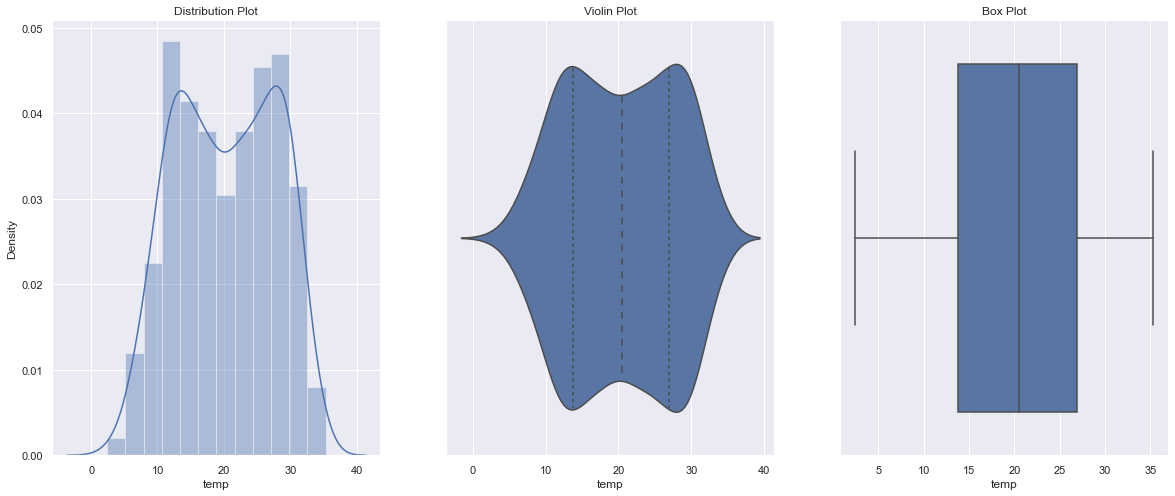

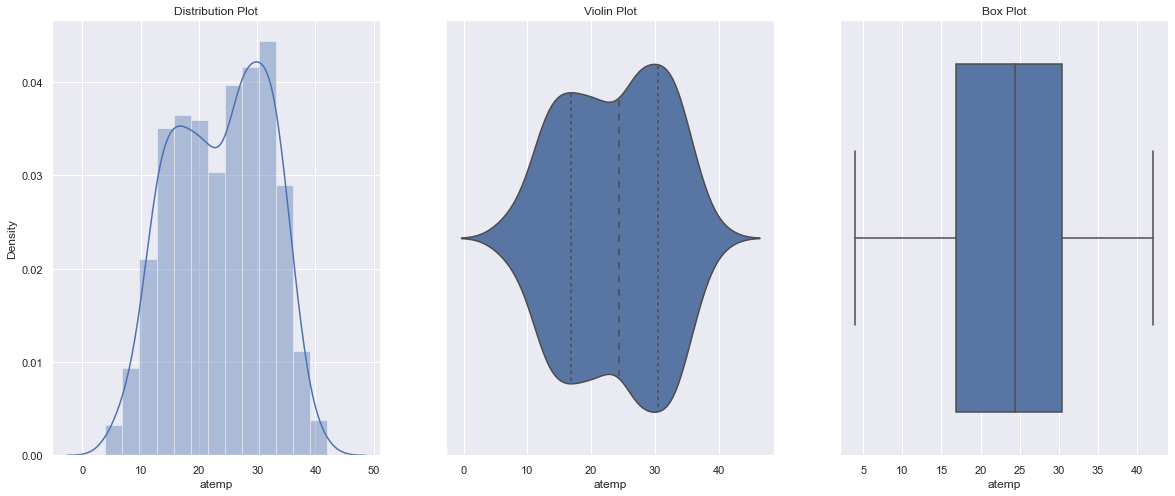

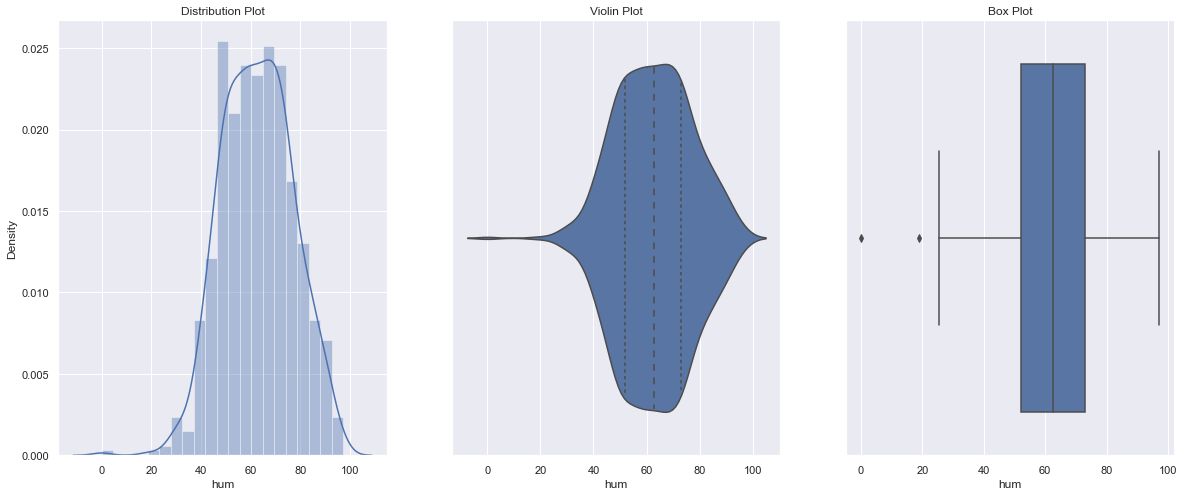

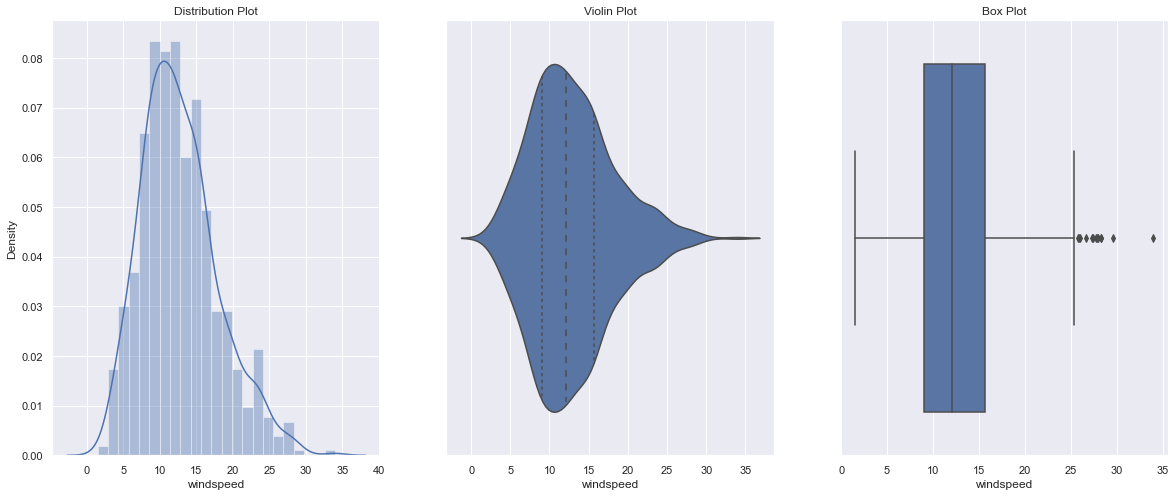

In [133]:
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed']
for col in numerical_columns:
    univar_plot(cleaned_data, col, 0)

In [132]:
## COMMENTS

# * The tempareature and ambient temperature are distributed from 10 to 30 in Celsius
# * The distribution of humidity are concentrated in between 40 and 90
# * Distribution of windspeed is around 5 to 20

#### Plot Categorical Data

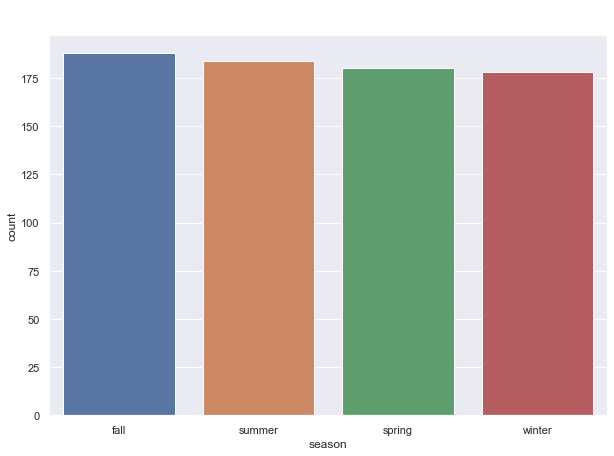

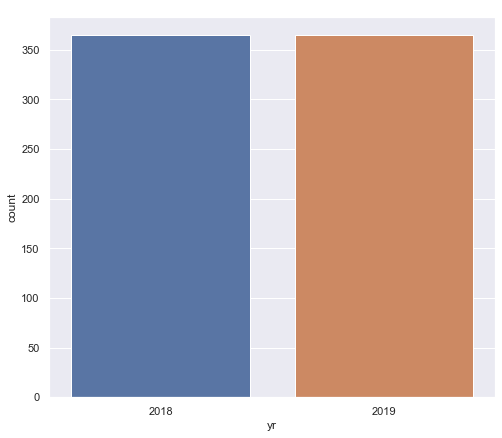

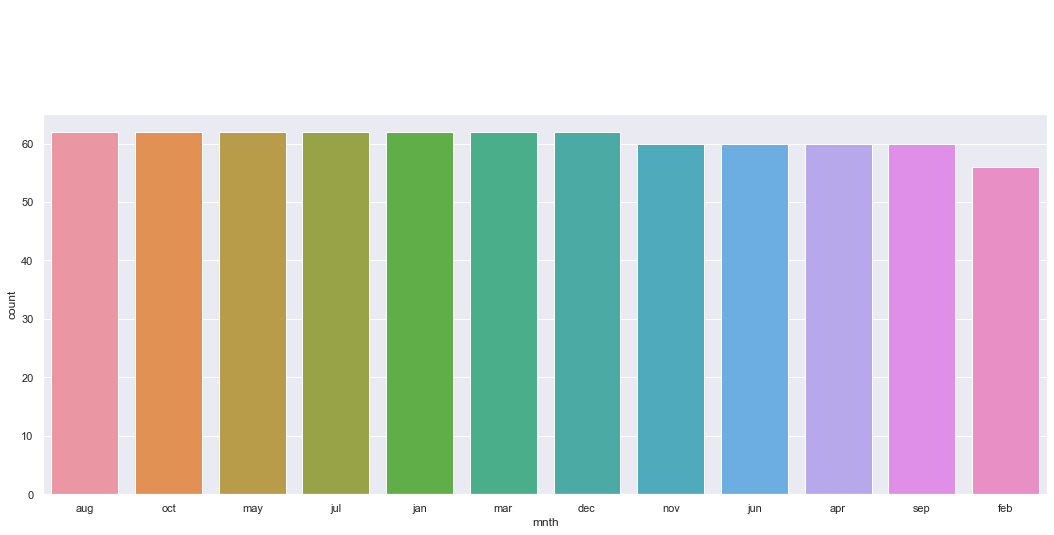

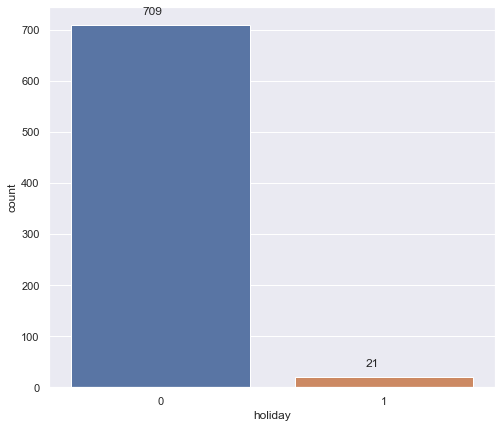

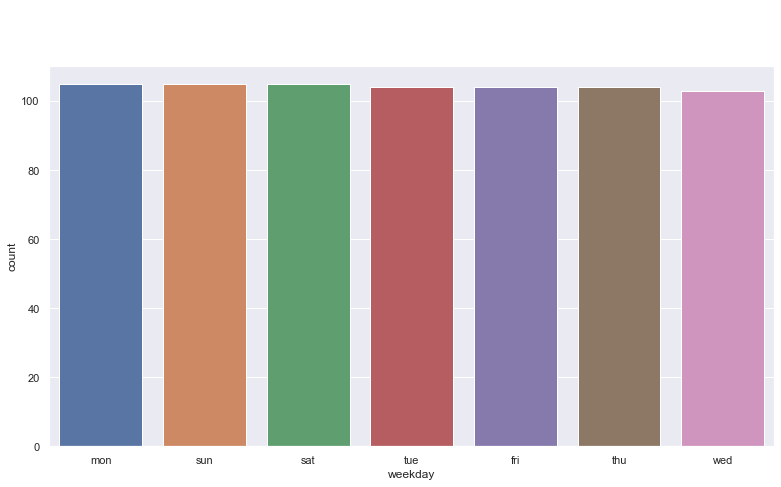

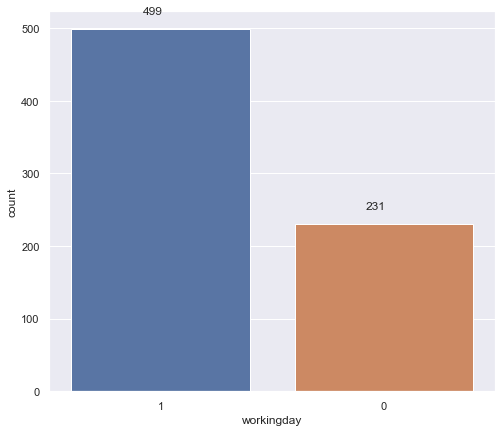

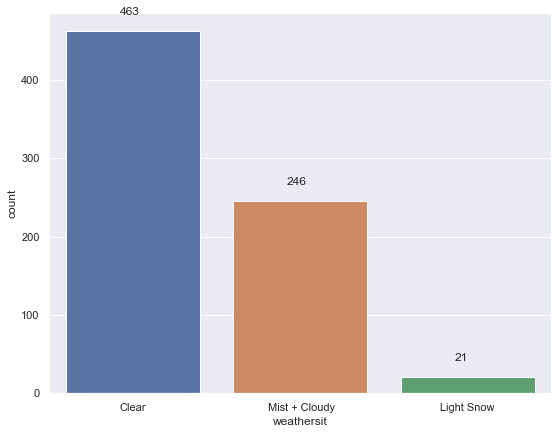

In [130]:
# Plotting Categorical Data with a loop

categorical_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
for col in categorical_columns:
    # Plotting Numeric Data: 'season'
    univar_plot(cleaned_data, col, 1)

In [139]:
## COMMENTS

# * Most of the records are of non-holidays days.
# * The number of records of working day is more than non-working days.
# * Most of the records are from Clear weather. Only a few from Light Snow.

### Bivariable Analysis

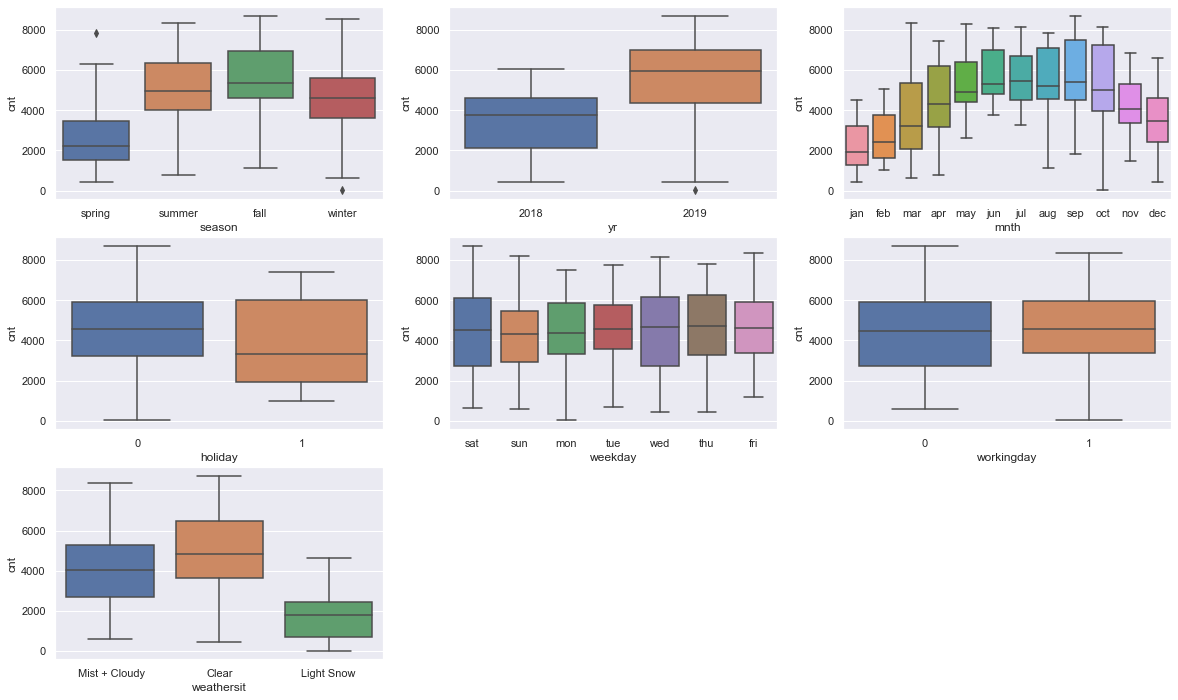

In [136]:
# Plotting BoxPlot of target variable vs independent variables 

plt.figure(figsize=(20,12))
plt.subplot(3,3,1)
sns.boxplot(x='season', y='cnt', data=cleaned_data);
plt.subplot(3,3,2)
sns.boxplot(x='yr', y='cnt', data=cleaned_data);
plt.subplot(3,3,3)
sns.boxplot(x='mnth', y='cnt', data=cleaned_data);
plt.subplot(3,3,4)
sns.boxplot(x='holiday', y='cnt', data=cleaned_data);
plt.subplot(3,3,5)
sns.boxplot(x='weekday', y='cnt', data=cleaned_data);
plt.subplot(3,3,6)
sns.boxplot(x='workingday', y='cnt', data=cleaned_data);
plt.subplot(3,3,7)
sns.boxplot(x='weathersit', y='cnt', data=cleaned_data);

Text(0.5, 1.0, 'windspeed vs Count')

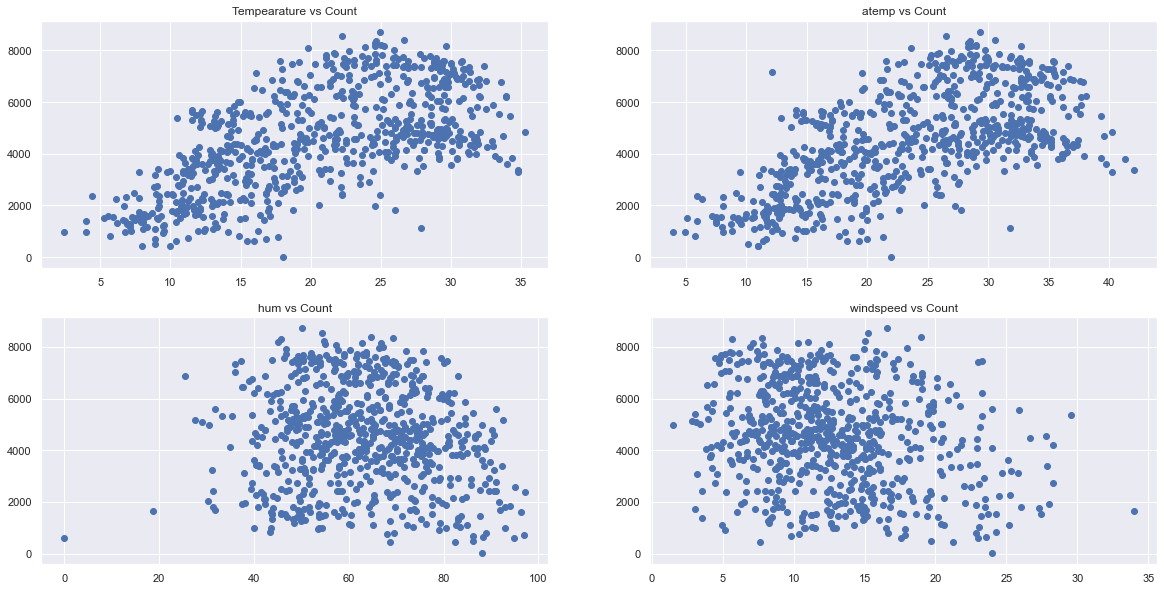

In [138]:
# Plotting Scatter plot of target variable vs independent variables 

plt.figure(figsize=(20,10))

# Plotting scatter plot for Tempearature vs Count
plt.subplot(2,2,1)
plt.scatter(data=cleaned_data, x='temp', y='cnt')
plt.title('Tempearature vs Count')

# Plotting scatter plot for atemp vs Count
plt.subplot(2,2,2)
plt.scatter(data=cleaned_data, x='atemp', y='cnt')
plt.title('atemp vs Count')

# Plotting scatter plot for hum vs Count
plt.subplot(2,2,3)
plt.scatter(data=cleaned_data, x='hum', y='cnt')
plt.title('hum vs Count')

# Plotting scatter plot for windspeed vs Count
plt.subplot(2,2,4)
plt.scatter(data=cleaned_data, x='windspeed', y='cnt')
plt.title('windspeed vs Count')

In [141]:
## COMMENTS

# As ambient temprature increase the count also increases as like temp vs cnt
# It showing that as the temperature increases the bike booking count also increases.
# Hum and wind speed does not show any strong relationship with cnt

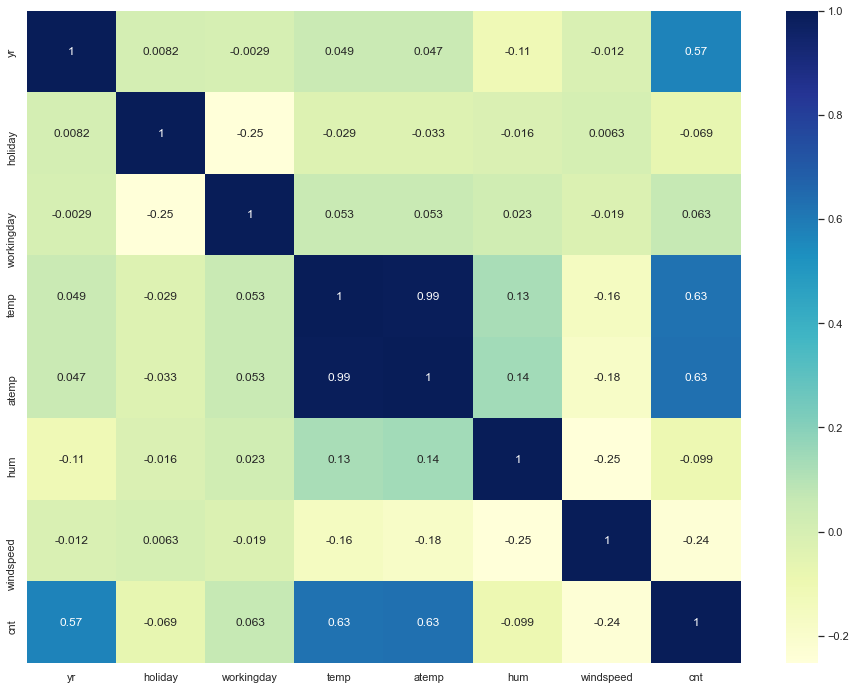

In [146]:
# Check for correlation between variables

plt.figure(figsize = (16, 12))
sns.heatmap(cleaned_data.corr(), annot= True, cmap="YlGnBu")
plt.show()

In [148]:
## COMMENTS

# * It shows that only Year, temp, atemp has a strong positive correlation with cnt.
# * Weather situation, windspeed and little bit humidity and holiday affects negatively.

## Preparing the Data for Modeling

* Convert Categorical variables to Dummy Variables : season, mnth, weekday, weathersit
* Splitting the Dataset for Train and Test

In [152]:
# Verifying how much memory is used by cleaned_data dataframe
cleaned_data_size_mb = format(sys.getsizeof(cleaned_data) /(1028**2), '.0f')

print(f'Cleaned_Data Memory Usage: {cleaned_data_size_mb}MB')

Cleaned_Data Memory Usage: 0MB


In [153]:
# Creating a copy of 'cleaned_data' to prepare the data for modeling
prepared_data = cleaned_data

In [154]:
# Creating dummy variables for season
seasons = pd.get_dummies(prepared_data.season, drop_first=True)
seasons.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [155]:
# Concat seasons with prepared_data and drop season column
prepared_data = pd.concat([prepared_data, seasons], axis = 1)
prepared_data.drop('season', axis = 1, inplace=True)
prepared_data.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,2018-01-01,2018,jan,0,sat,0,Mist + Cloudy,14.11,18.18,80.58,10.75,985,1,0,0
1,2018-02-01,2018,jan,0,sun,0,Mist + Cloudy,14.90,17.69,69.61,16.65,801,1,0,0
2,2018-03-01,2018,jan,0,mon,1,Clear,8.05,9.47,43.73,16.64,1349,1,0,0
3,2018-04-01,2018,jan,0,tue,1,Clear,8.20,10.61,59.04,10.74,1562,1,0,0
4,2018-05-01,2018,jan,0,wed,1,Clear,9.31,11.46,43.70,12.52,1600,1,0,0


In [156]:
# Creating dummy variables for mnth
months = pd.get_dummies(prepared_data.mnth, drop_first=True)
months.head()

,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [157]:
# Concat months with prepared_data and drop mnth column
prepared_data = pd.concat([prepared_data, months], axis = 1)
prepared_data.drop('mnth', axis = 1, inplace=True)
prepared_data.head()

,dteday,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,2018-01-01,2018,0,sat,0,Mist + Cloudy,14.11,18.18,80.58,10.75,...,0,0,1,0,0,0,0,0,0,0
1,2018-02-01,2018,0,sun,0,Mist + Cloudy,14.90,17.69,69.61,16.65,...,0,0,1,0,0,0,0,0,0,0
2,2018-03-01,2018,0,mon,1,Clear,8.05,9.47,43.73,16.64,...,0,0,1,0,0,0,0,0,0,0
3,2018-04-01,2018,0,tue,1,Clear,8.20,10.61,59.04,10.74,...,0,0,1,0,0,0,0,0,0,0
4,2018-05-01,2018,0,wed,1,Clear,9.31,11.46,43.70,12.52,...,0,0,1,0,0,0,0,0,0,0


In [158]:
# Creating dummy variables for weekday
weekdays = pd.get_dummies(prepared_data.weekday, drop_first=True)
weekdays.head()

,mon,sat,sun,thu,tue,wed
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1


In [159]:
# Concat months with prepared_data and drop mnth column
prepared_data = pd.concat([prepared_data, weekdays], axis = 1)
prepared_data.drop('weekday', axis = 1, inplace=True)
prepared_data.head()

,dteday,yr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,...,may,nov,oct,sep,mon,sat,sun,thu,tue,wed
0,2018-01-01,2018,0,0,Mist + Cloudy,14.11,18.18,80.58,10.75,985,...,0,0,0,0,0,1,0,0,0,0
1,2018-02-01,2018,0,0,Mist + Cloudy,14.90,17.69,69.61,16.65,801,...,0,0,0,0,0,0,1,0,0,0
2,2018-03-01,2018,0,1,Clear,8.05,9.47,43.73,16.64,1349,...,0,0,0,0,1,0,0,0,0,0
3,2018-04-01,2018,0,1,Clear,8.20,10.61,59.04,10.74,1562,...,0,0,0,0,0,0,0,0,1,0
4,2018-05-01,2018,0,1,Clear,9.31,11.46,43.70,12.52,1600,...,0,0,0,0,0,0,0,0,0,1


In [160]:
# Creating dummy variables for weathersit
weather = pd.get_dummies(prepared_data.weathersit, drop_first=True)
weather.head()

,Clear,Light Snow
0,0,0
1,0,0
2,1,0
3,1,0
4,1,0


In [161]:
# Concat months with prepared_data and drop mnth column
prepared_data = pd.concat([prepared_data, weather], axis = 1)
prepared_data.drop('weathersit', axis = 1, inplace=True)
prepared_data.head()

,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,...,oct,sep,mon,sat,sun,thu,tue,wed,Clear,Light Snow
0,2018-01-01,2018,0,0,14.11,18.18,80.58,10.75,985,1,...,0,0,0,1,0,0,0,0,0,0
1,2018-02-01,2018,0,0,14.90,17.69,69.61,16.65,801,1,...,0,0,0,0,1,0,0,0,0,0
2,2018-03-01,2018,0,1,8.05,9.47,43.73,16.64,1349,1,...,0,0,1,0,0,0,0,0,1,0
3,2018-04-01,2018,0,1,8.20,10.61,59.04,10.74,1562,1,...,0,0,0,0,0,0,1,0,1,0
4,2018-05-01,2018,0,1,9.31,11.46,43.70,12.52,1600,1,...,0,0,0,0,0,0,0,1,1,0


In [162]:
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      730 non-null    datetime64[ns]
 1   yr          730 non-null    int64         
 2   holiday     730 non-null    int64         
 3   workingday  730 non-null    int64         
 4   temp        730 non-null    float64       
 5   atemp       730 non-null    float64       
 6   hum         730 non-null    float64       
 7   windspeed   730 non-null    float64       
 8   cnt         730 non-null    int64         
 9   spring      730 non-null    uint8         
 10  summer      730 non-null    uint8         
 11  winter      730 non-null    uint8         
 12  aug         730 non-null    uint8         
 13  dec         730 non-null    uint8         
 14  feb         730 non-null    uint8         
 15  jan         730 non-null    uint8         
 16  jul         730 non-null  

### Splitting data into train test

In [170]:
data_train, data_test = train_test_split(prepared_data, train_size = 0.7, random_state = 100)
print(data_train.shape)
print(data_test.shape)

(510, 31)
(220, 31)


### Rescaling the Numeric Variables

It is important to re-scale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be far largeer or smaller as compared to the other coefficients. Not doing rescaling will add complexity to the model evaluation.

**I will not re-scale the target variable, which is cnt in our case.**

In [171]:
# 1. Instantiate a MinMaxScaler
scaler = MinMaxScaler()

# 2. Create a list of numeric variables
numvars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
data_train[numvars].head()

,temp,atemp,hum,windspeed,cnt
576,29.25,33.14,70.42,11.08,7216
426,16.98,20.67,62.12,10.79,4066
728,10.49,11.59,48.33,23.50,1796
482,15.44,18.88,48.96,8.71,4220
111,13.80,16.10,72.96,14.71,1683


In [172]:
# 3. Fit and Transform the data
data_train[numvars] = scaler.fit_transform(data_train[numvars])
data_train.head()

,dteday,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,...,oct,sep,mon,sat,sun,thu,tue,wed,Clear,Light Snow
576,2019-07-31,2019,0,1,0.82,0.77,0.73,0.26,0.83,0,...,0,0,0,0,0,0,1,0,1,0
426,2019-03-03,2019,0,0,0.44,0.44,0.64,0.26,0.47,1,...,0,0,0,1,0,0,0,0,0,0
728,2019-12-30,2019,0,0,0.25,0.20,0.50,0.66,0.20,1,...,0,0,0,0,1,0,0,0,1,0
482,2019-04-28,2019,0,0,0.40,0.39,0.50,0.19,0.48,0,...,0,0,0,1,0,0,0,0,0,0
111,2018-04-22,2018,0,1,0.35,0.32,0.75,0.38,0.19,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
data_train[numvars].describe()

,temp,atemp,hum,windspeed,cnt
count,510.00,510.00,510.00,510.00,510.00
mean,0.54,0.51,0.65,0.32,0.51
std,0.23,0.21,0.15,0.17,0.22
min,0.00,0.00,0.00,0.00,0.00
25%,0.34,0.33,0.54,0.20,0.36
50%,0.54,0.53,0.65,0.30,0.52
75%,0.74,0.69,0.75,0.41,0.68
max,1.00,1.00,1.00,1.00,1.00


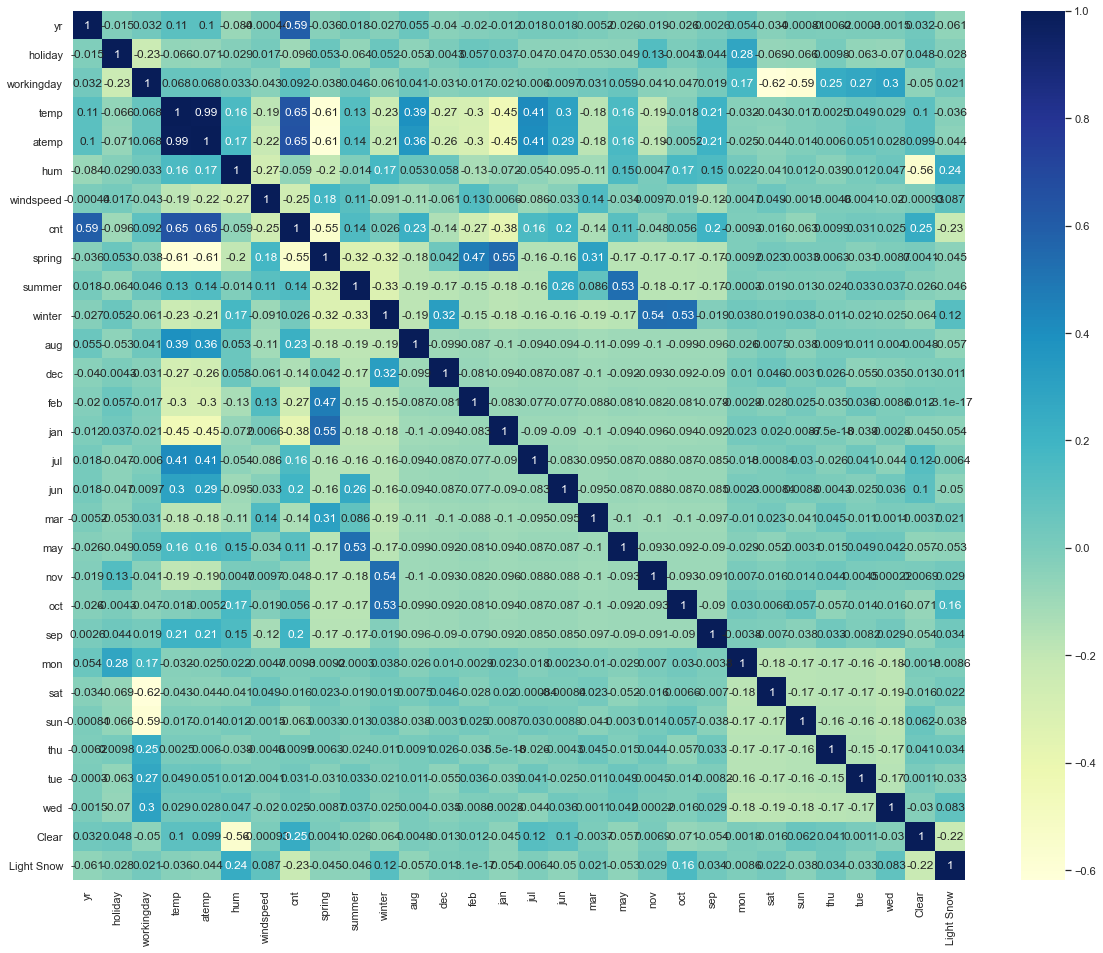

In [176]:
# Plotting correlation heat map
plt.figure(figsize = (20, 16))
sns.heatmap(data_train.corr(), annot= True, cmap="YlGnBu")
plt.show()

In [175]:
## COMMENTS

# * Temperature and year seems to the correlated to price the most.

## Model Building

## Model Testing

## Conclusions and Observations